In [22]:
import cv2 as cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from update_DB import Update_DB
from query import Thumbnails

In [40]:
udb = Update_DB()
udb.loadImages()
udb.calculateMean()
udb.preprocess_data()

fm = udb.get_features('fc7')
print(fm.shape)

(133, 4096)


133
8778
17556


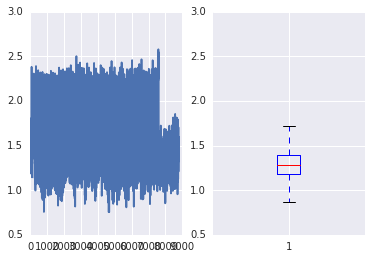

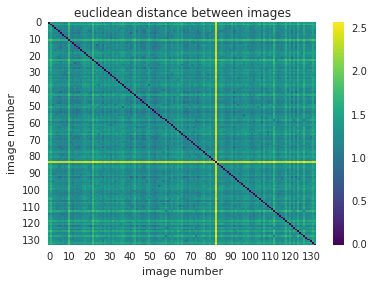

In [46]:
import itertools
import seaborn as sns

num_img = fm.shape[0]
print(num_img)
# number of possible combinations 
num_comb = (num_img)*(num_img-1)/2
num_perm = (num_img)*(num_img-1)
print(num_comb)
print(num_perm)

def _calc_rmse(fm1, fm2):
    return np.sqrt(np.mean((fm1-fm2)**2))

vect_comb = np.zeros([num_comb,3])
comb_matrix = np.zeros([num_img,num_img])
for i, comb in enumerate(itertools.combinations(np.arange(num_img), 2)):
    vect_comb[i,0:2] = np.array(comb)
    rmse   = _calc_rmse(fm[comb[0],:],fm[comb[1],:])
    vect_comb[i,2]   = rmse
    comb_matrix[comb[0],comb[1]] = rmse
    comb_matrix[comb[1],comb[0]] = rmse

vect_perm = np.zeros([num_perm,3])
for i, perm in enumerate(itertools.permutations(np.arange(num_img), 2)):
    vect_perm[i,0:2] = np.array(perm)
    vect_perm[i,2]   = _calc_rmse(fm[perm[0],:],fm[perm[1],:])

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(vect_comb[:,2][:])
ax2.boxplot(vect_comb[:,2][:])
plt.show()

comb_df = pd.DataFrame(comb_matrix)

fm_plot = sns.heatmap(comb_matrix,  xticklabels = 10, yticklabels = 10, cmap = 'viridis')
fm_plot.set(xlabel='image number', ylabel='image number', title = 'euclidean distance between images')
fig = fm_plot.get_figure()
fig.savefig('feature_map_plot.png')

#comb_df

In [45]:
comb_matrix[21,:]

array([ 1.37964256,  1.55363263,  1.24311001,  1.20071198,  1.17637319,
        0.97434656,  1.07217267,  1.17515659,  1.10967482,  1.18889196,
        1.61655665,  1.12126284,  1.05819009,  1.09648823,  1.0973847 ,
        0.99943147,  1.10005064,  1.25142979,  1.35629419,  1.28268038,
        1.17538929,  0.        ,  1.54946285,  1.23474435,  1.2211921 ,
        1.17115278,  1.21912654,  1.01314525,  1.30531477,  1.17536451,
        1.27079628,  1.10338217,  1.3009072 ,  1.19580982,  1.27713787,
        1.22901394,  1.27785597,  1.3104081 ,  1.24256103,  1.14566471,
        1.20388129,  1.00738049,  1.09514992,  1.44633375,  0.99501843,
        1.29805815,  1.11878249,  0.93939536,  1.01448872,  1.26100391,
        1.29327457,  1.16308589,  1.0901017 ,  1.03548339,  1.06988037,
        1.20910859,  1.26589972,  1.20429018,  1.40930017,  1.11948699,
        0.99032512,  1.28744492,  1.13910866,  1.16522856,  1.33202536,
        1.19368542,  1.39563682,  1.01733794,  1.11729764,  1.00

In [48]:
# get similar combinations list
std_fm = np.std(vect_comb[:,2])
mean_fm = np.mean(vect_comb[:,2])
print('MEAN: %.2f, STD: %.2f' % (mean_fm, std_fm))

fm_df = pd.DataFrame(vect_comb[:,:])
fm_df.dtypes
fm_df[[0,1]] = fm_df[[0,1]].astype(int)
threshold = (mean_fm-2.5*std_fm)
threshold = 0.9
comb_similar = fm_df.loc[fm_df[2] <  threshold]
print(udb.img_filenames[21])
comb_similar

MEAN: 1.31, STD: 0.21
IMG_20141201_162820001.jpg


,0,1,2
736,5,92,0.889850
811,6,41,0.755761
823,6,53,0.850961
1648,13,24,0.826651
1794,14,52,0.888782
1865,14,123,0.875889
2661,21,121,0.816168
3233,27,48,0.845291
3277,27,92,0.887163
3853,33,59,0.879564


In [49]:
mean_fm-2.5*std_fm

0.79739865259306741

In [50]:
# get similar permutations list
fm_df = pd.DataFrame(vect_perm[:,:])
fm_df.dtypes
fm_df[[0,1]] = fm_df[[0,1]].astype(int)

perm_similar = fm_df.loc[fm_df[2] <  threshold]
perm_similar.shape
perm_similar
# np.unique(comb_similar[0:2])

,0,1,2
751,5,92,0.889850
832,6,41,0.755761
844,6,53,0.850961
1739,13,24,0.826651
1899,14,52,0.888782
1970,14,123,0.875889
2892,21,121,0.816168
3181,24,13,0.826651
3611,27,48,0.845291
3655,27,92,0.887163


In [51]:
# plt.imshow(udb.images[0])
# plt.imshow(udb.images[1][0])
def get_filename_lst(similar_df):
    unique_original_lst = similar_df[0].unique()
    filenames_lst = []
    
    for unique_idx in unique_original_lst:      
        # similar indexes
        original_idx = unique_idx
#         print(original_idx)
        similar_idxs = [int(i) for i in similar_df[similar_df[0] == unique_idx].values[:, 1] ]
#         print(similar_idxs)
        # similar filenames
        similar_fnms_lst = [udb.img_filenames[original_idx]]
        similar_fnms_lst.extend([udb.img_filenames[idx] for idx in similar_idxs] )
#         print(similar_fnms_lst)

        filenames_lst.append(similar_fnms_lst)
    
    return filenames_lst

In [52]:
print(get_filename_lst(perm_similar))


[['IMG_1870.JPG', '20150830_181302.jpg'], ['20160720_075849-1.jpg', 'IMG_20160531_143739357.jpg', 'P_Monterosso_seaside.jpg'], ['2015-02-11 15.50.44.jpg', '2015-02-11 15.51.04.jpg'], ['IMG_1593.JPG', 'Screenshot_2016-07-20-11-25-17-1.png', '2015-08-15 14.30.49.jpg'], ['IMG_20141201_162820001.jpg', 'IMG_20141206_143527909.jpg'], ['2015-02-11 15.51.04.jpg', '2015-02-11 15.50.44.jpg'], ['25282615.jpg', 'IMG_2384.JPG', '20150830_181302.jpg'], ['2016-05-29 22.47.55.jpg', '2015-03-07 18.50.15.jpg'], ['IMG_20160531_143739357.jpg', '20160720_075849-1.jpg', 'P_Monterosso_seaside.jpg', 'IMG_20141118_123454075.jpg', '20150830_181302.jpg', '2015-08-15 14.30.49.jpg'], ['IMG_20141206_144523810.jpg', 'IMG_2384.JPG', '20150830_181302.jpg', 'IMG_20141206_143527909.jpg'], ['IMG_20160601_143735105.jpg', 'IMG_2384.JPG', 'IMG_20141118_123454075.jpg'], ['IMG_2384.JPG', '25282615.jpg', 'IMG_20141206_144523810.jpg', 'IMG_20160601_143735105.jpg', '20150830_181302.jpg'], ['Screenshot_2016-07-20-11-25-17-1.png',

In [54]:
prev_fnm_lst = get_filename_lst(perm_similar)

for img_lst in prev_fnm_lst:
    prev = Thumbnails(227, 2, 5)
    prev.create_preview( img_lst)
    prev.save_to_file('image_data/similar_images/similar_to_' + img_lst[0] + '.png')